In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from cascid.datasets.pipeline.load_dataset import train_test_split
from cascid.datasets.isic.fetcher import fetch_from_isic, save_metadata, download_image
from cascid.image import apply_preprocessing

In [2]:
# images = fetch_from_isic(100, [
#     "melanoma",
#     "nevus",
#     '"basal cell carcinoma"',
#     '"seborrheic keratosis"',
#     '"actinic keratosis"',
#     '"squamous cell carcinoma"'
#     ])

# save_metadata(image_list=images)

In [3]:
image_metadata = pd.read_csv(r'C:\Users\samuel.nporto\.cascid_data\ISIC\metadata.csv')

image_metadata

,Unnamed: 0,isic_id,sex,diagnostic,age_approx,image_url,img_id
0,0,ISIC_6892286,male,melanoma,75,https://content.isic-archive.com/e854396c-7cae...,ISIC_6892286.jpg
1,1,ISIC_9214649,male,melanoma,60,https://content.isic-archive.com/c7069eb7-7394...,ISIC_9214649.jpg
2,2,ISIC_3056854,male,melanoma,75,https://content.isic-archive.com/45f9a250-e9c7...,ISIC_3056854.jpg
3,3,ISIC_7755096,male,melanoma,45,https://content.isic-archive.com/78d98772-82b9...,ISIC_7755096.jpg
4,4,ISIC_9859873,female,melanoma,75,https://content.isic-archive.com/d8e858ca-c0dc...,ISIC_9859873.jpg
...,...,...,...,...,...,...,...
595,595,ISIC_0070213,male,squamous cell carcinoma,85,https://content.isic-archive.com/1f2f57ba-df7d...,ISIC_0070213.jpg
596,596,ISIC_0070157,male,squamous cell carcinoma,75,https://content.isic-archive.com/2b1b32d5-7fac...,ISIC_0070157.jpg
597,597,ISIC_0070083,male,squamous cell carcinoma,65,https://content.isic-archive.com/9e9fe854-d36f...,ISIC_0070083.jpg
598,598,ISIC_0070041,female,squamous cell carcinoma,65,https://content.isic-archive.com/24a2a7f9-717d...,ISIC_0070041.jpg


In [4]:
# for id in image_metadata.isic_id:
#     download_image(id)

In [5]:
x_train, x_test, y_train, y_test = train_test_split('isic', 'raw')

def rotateImage(image, angle, center):
    row,col, *c = image.shape # Get image shape, discarding any color channels available
    rot_mat = cv2.getRotationMatrix2D(center,angle,1.0) # Make a rotation matrix using
    new_image = cv2.warpAffine(image, rot_mat, (col,row))
    return new_image

Loading raw isic dataset, this may take a minute, but caching is done automatically, so the next time it should be much faster.


# Feature Extraction for 1 Image

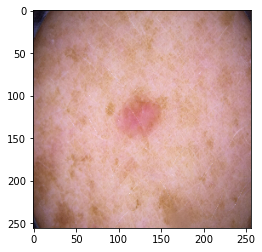

In [6]:
im = x_train[25]
plt.imshow(im)

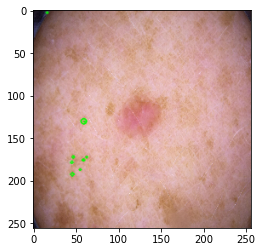

In [7]:
# Initiate ORB detector
orb = cv2.SIFT_create()
# find the keypoints with ORB
kp = orb.detect(im,None)
# compute the descriptors with ORB
kp, des = orb.compute(im, kp)
# draw
img2 = cv2.drawKeypoints(im, kp[:10], None, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img2)
plt.show();

In [8]:
kp[0].pt, kp[0].angle

((16.102256774902344, 2.551375389099121), 25.399169921875)

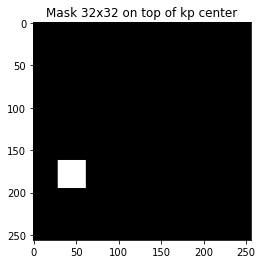

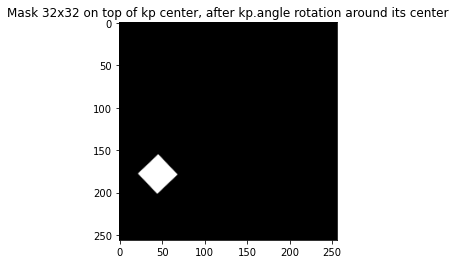

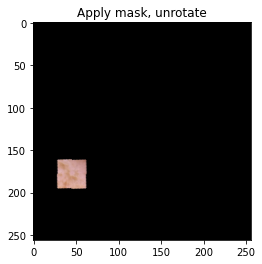

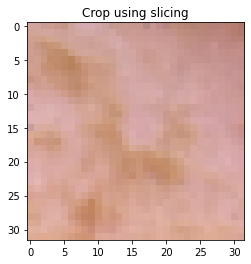

(25, 1024)


In [9]:
width = 32
plot_example = True
M = list()
for i in range(len(kp)):
    x = int(kp[i].pt[0]) # int conversion
    y = int(kp[i].pt[1]) # int conversion
    angle = kp[i].angle # angle in deg

    # Check for boundary
    if x<width//2 or x > (im.shape[1] - width//2) or y<width//2 or y > (im.shape[0] - width//2):
        continue

    mask = np.zeros_like(im) # black mask 
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY) # grayscale
    mask = cv2.rectangle(mask, (x-width//2, y+width//2), (x+width//2, y-width//2), 255, -1) # draw square
    mask_rot = rotateImage(mask, angle, (x,y)) # rotate square by angle
    roi = cv2.bitwise_and(im, im, mask=mask_rot) # Select mask region
    roi = rotateImage(roi, -angle, (x,y)) # unrotate
    roi_32 = roi[ y-width//2 : y+width//2 , x-width//2 : x+width//2 ] # crop
    if plot_example:
        plt.imshow(mask, cmap='gray')
        plt.title('Mask 32x32 on top of kp center')
        plt.show()
        plt.imshow(mask_rot, cmap='gray')
        plt.title('Mask 32x32 on top of kp center, after kp.angle rotation around its center')
        plt.show()
        plt.imshow(roi)
        plt.title('Apply mask, unrotate')
        plt.show()
        plt.imshow(roi_32)
        plt.title('Crop using slicing')
        plt.show()
        plot_example = False # Only show first
    roi_32 = cv2.cvtColor(roi_32, cv2.COLOR_RGB2LAB) # Convert to CIE-LAB
    roi_32 = roi_32[:,:,0] # Keep only L
    M.append(roi_32.flatten())
M = np.array(M)
print(M.shape)

In [13]:
u, s, vh = np.linalg.svd(M, full_matrices=False)

print(u.shape)
print(s.shape)
print(vh.shape)

(25, 25)
(25,)
(25, 1024)


In [36]:
for e in range(len(s)):
    vh[e] = s[e]*vh[e]

In [46]:
result = np.zeros(len(vh[0]))

for e in vh:
    result += e

result

array([-24715419.87858999, -24699768.61479791, -24760436.43538896, ...,
       -24757991.54980594, -24826391.78337056, -24749886.38745469])

# Model Classification